### Packages

In [1]:
cd '/h/ama/workspace/ama-at-vector/best-mix'

/scratch/ssd001/home/ama/workspace/ama-at-vector/best-mix


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import math
import pickle

from mixup import mixup_graph

os.environ['KMP_DUPLICATE_LIB_OK']='True'
%matplotlib inline

In [4]:
def print_fig(input, target=None, title=None, save_dir=None):
    fig, axes = plt.subplots(1,len(input),figsize=(3*len(input),3))
    if title:
        fig.suptitle(title, size=16)
    if len(input) == 1 :
        axes = [axes]
        
    for i, ax in enumerate(axes):
        if len(input.shape) == 4:
            ax.imshow(input[i].permute(1,2,0).numpy())
        else :
            ax.imshow(input[i].numpy(), cmap='gray', vmin=0., vmax=1.)
        
        if target is not None:
            output = net((input[i].unsqueeze(0) - mean)/std)
            loss = criterion(output, target[i:i+1])
            ax.set_title("loss: {:.3f}\n pred: {}\n true : {}".format(loss, CIFAR100_LABELS_LIST[output.max(1)[1][0]], CIFAR100_LABELS_LIST[target[i]]))
        ax.axis('off')
    plt.subplots_adjust(wspace = 0.1)
    
    if save_dir is not None:
        plt.savefig(save_dir, bbox_inches = 'tight',  pad_inches = 0)
        
    plt.show()

### Model, Data, Saliency

In [5]:
''' Model '''
resnet = models.resnet18(pretrained=True)
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])
mean_torch = mean.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
std_torch = std.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)

resnet.eval()
criterion = nn.CrossEntropyLoss()

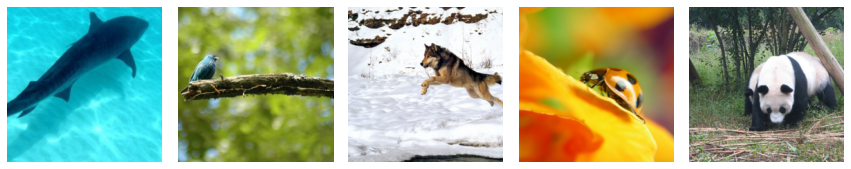

In [6]:
''' Data '''
img_exists = False 

if img_exists:
    # I used this codes to load data
    test_transform = transforms.Compose([
          transforms.Resize(256),
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          transforms.Normalize(mean=mean, std=std)])

    sample_num = 5
    valdir = os.path.join('/Users/janghyun/Documents/Datasets/ImageNet', 'val')
    val_dset = datasets.ImageFolder(valdir, test_transform)
    val_loader = torch.utils.data.DataLoader(val_dset, batch_size=sample_num, shuffle=False, num_workers=2)

    ### Selected Examples
    input_sp = torch.stack([val_dset[3*50][0], val_dset[14*50][0], val_dset[269*50+2][0], val_dset[301*50+0][0], val_dset[388*50+2][0]], dim=0)
    targets = torch.tensor([val_dset[3*50][1], val_dset[14*50][1], val_dset[269*50+2][1], val_dset[301*50+0][1], val_dset[388*50+2][1]])

else:
    sample_num = 5
    # I saved the processed images at figures folder
#     with open('figures/sample.data', 'rb') as file:
    with open('/h/ama/workspace/ama-at-vector/best-mix/figures/sample.data', 'rb') as file:
        input_sp, targets = pickle.load(file)
    
print_fig((input_sp * std_torch + mean_torch)[:sample_num])

In [7]:
''' Saliency '''
input_var = input_sp[:sample_num].clone().detach().requires_grad_(True)
output = resnet(input_var)
loss = criterion(output, targets[:sample_num])
loss.backward()

blurr = torchvision.transforms.GaussianBlur(21, sigma=(13, 13))

grad = blurr(input_var.grad.detach().abs().mean(dim=1)).squeeze()
# grad = grad/grad.amax(dim=[1,2],keepdim=True).detach()
# grad_min = grad.amin(dim=[1,2],keepdim=True).detach()
# grad = (grad-grad_min)
# grad_max = grad.amax(dim=[1,2],keepdim=True).detach()
# grad = grad/grad_max

# print_fig(grad)

### Ours

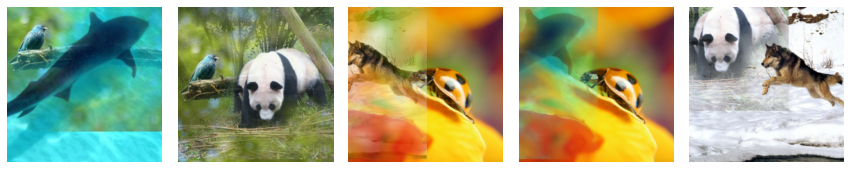

In [9]:
from utils_mixup import gradmix_v2

mixed_x, mixed_y, mixed_lam = gradmix_v2(input_sp.cuda(), targets.cuda(), grad.unsqueeze(1).cuda(), stride = 10, debug=True)

print_fig(mixed_x.cpu() * std_torch + mean_torch)

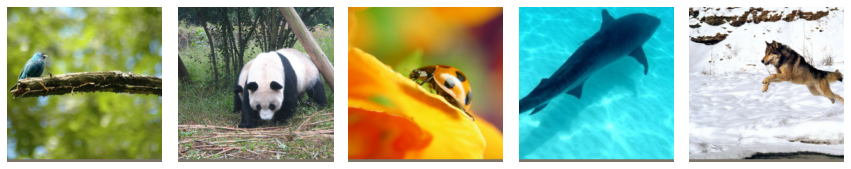

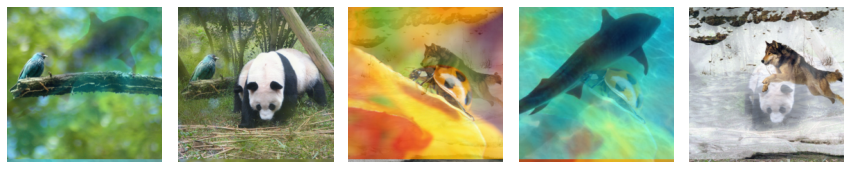

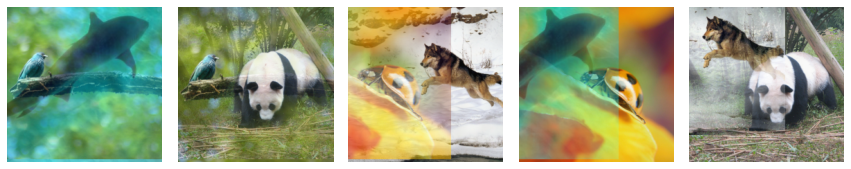

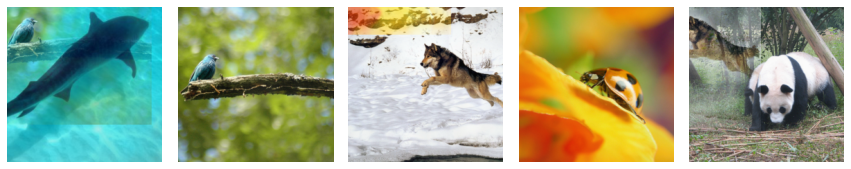

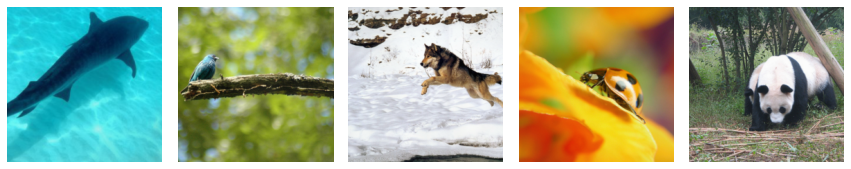

In [17]:
from utils_mixup import gradmix_v2

for _alpha in np.linspace(0,1,5):
    mixed_x, mixed_y, mixed_lam = gradmix_v2(input_sp.cuda(), targets.cuda(), grad.unsqueeze(1).cuda(), alpha=_alpha, normalization='L1', stride=5, debug=True)

    print_fig(mixed_x.cpu() * std_torch + mean_torch)